In [61]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import nltk

The dataset that will be used is all the [Proposed Amendments to the United States Constitution](https://www.archives.gov/open/dataset-amendments)

In [62]:
data = pd.read_csv('all_proposed_amendments.csv', encoding='ISO-8859-1')

#print(data.columns)
""" Returned:
Index(['identifier', 'source_code', 'source_citation', 'source_index_number',
       'title_or_description_from_source', 'date_approximation', 'year',
       'month', 'day', 'congress', 'congressional_session',
       'joint_resolution_chamber', 'joint_resolution_number', 'sponsor_name',
       'sponsor_state_or_territory', 'committee_of_referral', 'last_modified'],
      dtype='object')
"""
data

,identifier,source_code,source_citation,source_index_number,title_or_description_from_source,date_approximation,year,month,day,congress,congressional_session,joint_resolution_chamber,joint_resolution_number,sponsor_name,sponsor_state_or_territory,committee_of_referral,last_modified
0,us-nara-amending-america-000001,A,"Ames, Herman V. The Proposed Amendments to the...",1,Reservation of nondelegated powers,circa,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-25T17:29:59.732-05:00
1,us-nara-amending-america-000002,A,"Ames, Herman V. The Proposed Amendments to the...",2,Apportionment of Representatives,circa,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-25T17:29:59.732-05:00
2,us-nara-amending-america-000003,A,"Ames, Herman V. The Proposed Amendments to the...",3,Restriction on Federal control over election o...,circa,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-25T17:29:59.732-05:00
3,us-nara-amending-america-000004,A,"Ames, Herman V. The Proposed Amendments to the...",4,Restriction upon the levying of direct taxes,circa,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-25T17:29:59.732-05:00
4,us-nara-amending-america-000005,A,"Ames, Herman V. The Proposed Amendments to the...",5,Commercial monopolies prohibited,circa,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-25T17:29:59.732-05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11792,us-nara-amending-america-011793,G,United States Congress. Congress.gov: Legislat...,NaN,A joint resolution proposing an amendment to t...,NaN,2013.0,6.0,18.0,113.0,NaN,Senate Joint Resolution,19.0,"Udall, Tom",New Mexico,Judiciary,2016-02-25T17:29:59.732-05:00
11793,us-nara-amending-america-011794,G,United States Congress. Congress.gov: Legislat...,NaN,A joint resolution proposing a balanced budget...,NaN,2013.0,7.0,11.0,113.0,NaN,Senate Joint Resolution,20.0,"Udall, Tom",New Mexico,Judiciary,2016-02-25T17:29:59.732-05:00
11794,us-nara-amending-america-011795,G,United States Congress. Congress.gov: Legislat...,NaN,A joint resolution proposing an amendment to t...,NaN,2013.0,10.0,11.0,113.0,NaN,Senate Joint Resolution,25.0,"Paul, Rand",Kentucky,Judiciary,2016-02-25T17:29:59.732-05:00
11795,us-nara-amending-america-011796,G,United States Congress. Congress.gov: Legislat...,NaN,A joint resolution proposing an amendment to t...,NaN,2014.0,3.0,13.0,113.0,NaN,Senate Joint Resolution,34.0,"Enzi, Michael",Wyoming,Judiciary,2016-02-25T17:29:59.732-05:00


There may be some columns that have useless or little to no data in them, so they will be scowered through to determine which are needed.

In [63]:
for column in data.columns:
	group = data.groupby(column)
	if (len(group) < 100):
		print(f"{column} ({len(group)}): {group.groups.keys()}")

source_code (7): dict_keys(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
source_citation (7): dict_keys(['Ames, Herman V. The Proposed Amendments to the Constitution of the United States During the First Century of Its History, American Historical Society Annual Report for the year 1896; H. Doc. 353 part 2, 54th Cong., 2d Session, volume 3550-2, Washington: U.S. Government Printing Office, 1897.', 'Davis, Richard. Proposed Amendments to the Constitution of the United States Introduced in Congress from the 91st Congress, 1st Session through the 98th Congress, 2d Session, January 1969-December 1984, (CRS Report No. 85-36 GOV), Washington: Congressional Research Service, 1985.', 'Harris, Daryl B. Proposed Amendments to the Constitution: 99th-101st Congress (1985-1990), (CRS Report No. 92-555 GOV), Washington: Congressional Research Service, 1992.', 'Proposed Amendments to the Constitution of the United States Introduced in Congress from the 69th Congress, 2d Session through the 87th Congress, 2d S

Because the "source_code", "date_approximation", "last_modified" columns have almost no data, they will be dropped from the dataset.

In [64]:
data.drop(columns=['source_code', 'date_approximation', 'last_modified'], inplace=True)

In [65]:
data.groupby('sponsor_state_or_territory').size().sort_values(ascending=False)

sponsor_state_or_territory
New York            1012
Texas                635
California           622
Pennsylvania         590
Illinois             528
Ohio                 509
Florida              454
Michigan             347
Massachusetts        341
Missouri             333
Indiana              324
New Jersey           254
Alabama              254
Virginia             247
South Carolina       225
Tennessee            224
Wisconsin            223
North Carolina       219
Georgia              208
Kansas               204
Mississippi          199
Maryland             195
Minnesota            192
Louisiana            190
Kentucky             189
Oklahoma             166
Iowa                 163
Arkansas             130
Washington           126
Arizona              121
New Hampshire        118
Connecticut          114
Colorado             113
Oregon               111
Nebraska             108
West Virginia         98
South Dakota          84
North Dakota          81
Idaho                 7

There is a lot of duplicates within these proposed amendments since they go through multiple stages within Congress and HoS and could take months, I will filter out duplicates within their '<b>title_or_description_from_source</b>' column and keep the latest entry; first by tokenizing the column and filtering those duplicates.

In [66]:
# Tokenize the title_or_description_from_source column
data['title_tokens'] = data['title_or_description_from_source'].apply(
	lambda x: nltk.word_tokenize(x.lower()) if isinstance(x, str) else []
)

# Drop the duplicates within the 'title_tokens" column
data_unique = data.copy().drop_duplicates(subset='title_tokens', keep='last')

'''
To make a new csv file with the unique words:
data_unique.to_csv('all_proposed_amendments_cleaned.csv', index=False)
'''

print(data.shape)
print(data_unique.shape)
print(f'Dropped {data.shape[0] - data_unique.shape[0]} duplicate entries based on title_tokens.')
data_unique

(11797, 15)
(4627, 15)
Dropped 7170 duplicate entries based on title_tokens.


,identifier,source_citation,source_index_number,title_or_description_from_source,year,month,day,congress,congressional_session,joint_resolution_chamber,joint_resolution_number,sponsor_name,sponsor_state_or_territory,committee_of_referral,title_tokens
7,us-nara-amending-america-000008,"Ames, Herman V. The Proposed Amendments to the...",8,Trial by jury in civil action,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[trial, by, jury, in, civil, action]"
20,us-nara-amending-america-000021,"Ames, Herman V. The Proposed Amendments to the...",21,Trial by jury in civil cases,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[trial, by, jury, in, civil, cases]"
23,us-nara-amending-america-000024,"Ames, Herman V. The Proposed Amendments to the...",24,Religion,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[religion]
29,us-nara-amending-america-000030,"Ames, Herman V. The Proposed Amendments to the...",30,Publication of journals annually,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[publication, of, journals, annually]"
34,us-nara-amending-america-000035,"Ames, Herman V. The Proposed Amendments to the...",35,Period of enlistment of soldiers limited,1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[period, of, enlistment, of, soldiers, limited]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11792,us-nara-amending-america-011793,United States Congress. Congress.gov: Legislat...,NaN,A joint resolution proposing an amendment to t...,2013.0,6.0,18.0,113.0,NaN,Senate Joint Resolution,19.0,"Udall, Tom",New Mexico,Judiciary,"[a, joint, resolution, proposing, an, amendmen..."
11793,us-nara-amending-america-011794,United States Congress. Congress.gov: Legislat...,NaN,A joint resolution proposing a balanced budget...,2013.0,7.0,11.0,113.0,NaN,Senate Joint Resolution,20.0,"Udall, Tom",New Mexico,Judiciary,"[a, joint, resolution, proposing, a, balanced,..."
11794,us-nara-amending-america-011795,United States Congress. Congress.gov: Legislat...,NaN,A joint resolution proposing an amendment to t...,2013.0,10.0,11.0,113.0,NaN,Senate Joint Resolution,25.0,"Paul, Rand",Kentucky,Judiciary,"[a, joint, resolution, proposing, an, amendmen..."
11795,us-nara-amending-america-011796,United States Congress. Congress.gov: Legislat...,NaN,A joint resolution proposing an amendment to t...,2014.0,3.0,13.0,113.0,NaN,Senate Joint Resolution,34.0,"Enzi, Michael",Wyoming,Judiciary,"[a, joint, resolution, proposing, an, amendmen..."


In [67]:
# Search for rows that have the word "amendment" in title_or_description_from_source
amendment_data = data_unique[data_unique['title_or_description_from_source'].str.contains('amendment', case=False, na=False)]
print(amendment_data.shape)
amendment_data


(728, 15)


,identifier,source_citation,source_index_number,title_or_description_from_source,year,month,day,congress,congressional_session,joint_resolution_chamber,joint_resolution_number,sponsor_name,sponsor_state_or_territory,committee_of_referral,title_tokens
106,us-nara-amending-america-000107,"Ames, Herman V. The Proposed Amendments to the...",107,"After 1793, 11 of the original 13 states requi...",1788.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[after, 1793, ,, 11, of, the, original, 13, st..."
147,us-nara-amending-america-000148,"Ames, Herman V. The Proposed Amendments to the...",148,Amendment: Preamble: Submitted to the States,1789.0,8.0,13.0,1.0,1,NaN,NaN,NaN,NaN,NaN,"[amendment, :, preamble, :, submitted, to, the..."
186,us-nara-amending-america-000187,"Ames, Herman V. The Proposed Amendments to the...",187,Amendments: Proposed by the States,1789.0,8.0,18.0,NaN,NaN,NaN,NaN,Gerry,Massachusetts,NaN,"[amendments, :, proposed, by, the, states]"
323,us-nara-amending-america-000324,"Ames, Herman V. The Proposed Amendments to the...",321,Extent of jurisdiction. (The XI Amendment),1794.0,1.0,2.0,3.0,1,NaN,NaN,NaN,NaN,NaN,"[extent, of, jurisdiction, ., (, the, xi, amen..."
616,us-nara-amending-america-000617,"Ames, Herman V. The Proposed Amendments to the...",571,Amendments only to be proposed decennially,1826.0,3.0,8.0,19.0,1,NaN,NaN,Herrick,Maine,NaN,"[amendments, only, to, be, proposed, decennially]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11792,us-nara-amending-america-011793,United States Congress. Congress.gov: Legislat...,NaN,A joint resolution proposing an amendment to t...,2013.0,6.0,18.0,113.0,NaN,Senate Joint Resolution,19.0,"Udall, Tom",New Mexico,Judiciary,"[a, joint, resolution, proposing, an, amendmen..."
11793,us-nara-amending-america-011794,United States Congress. Congress.gov: Legislat...,NaN,A joint resolution proposing a balanced budget...,2013.0,7.0,11.0,113.0,NaN,Senate Joint Resolution,20.0,"Udall, Tom",New Mexico,Judiciary,"[a, joint, resolution, proposing, a, balanced,..."
11794,us-nara-amending-america-011795,United States Congress. Congress.gov: Legislat...,NaN,A joint resolution proposing an amendment to t...,2013.0,10.0,11.0,113.0,NaN,Senate Joint Resolution,25.0,"Paul, Rand",Kentucky,Judiciary,"[a, joint, resolution, proposing, an, amendmen..."
11795,us-nara-amending-america-011796,United States Congress. Congress.gov: Legislat...,NaN,A joint resolution proposing an amendment to t...,2014.0,3.0,13.0,113.0,NaN,Senate Joint Resolution,34.0,"Enzi, Michael",Wyoming,Judiciary,"[a, joint, resolution, proposing, an, amendmen..."


In [68]:
''' Keeping track of all the ratified amendments
Amendment: Index/Row Within DataFrame
Preamble: 147
1-10 Amendments (Bill of Rights): 186
11th Amendment: 323
12th Amendment: 
13th Amendment: 1102
14th Amendment: 1283
15th Amendment: 1466
18th Amendment: 3320
19th Amendment: 
20th Amendment: 3424
21st Amendment: 3448
22nd Amendment: 4284
'''

ratified_amendments = data.loc[[147, 186, 323, 1102, 1283, 1466, 3320, 3424, 3448, 4284]]
print(ratified_amendments.shape)
ratified_amendments

(10, 15)


,identifier,source_citation,source_index_number,title_or_description_from_source,year,month,day,congress,congressional_session,joint_resolution_chamber,joint_resolution_number,sponsor_name,sponsor_state_or_territory,committee_of_referral,title_tokens
147,us-nara-amending-america-000148,"Ames, Herman V. The Proposed Amendments to the...",148,Amendment: Preamble: Submitted to the States,1789.0,8.0,13.0,1.0,1,NaN,NaN,NaN,NaN,NaN,"[amendment, :, preamble, :, submitted, to, the..."
186,us-nara-amending-america-000187,"Ames, Herman V. The Proposed Amendments to the...",187,Amendments: Proposed by the States,1789.0,8.0,18.0,NaN,NaN,NaN,NaN,Gerry,Massachusetts,NaN,"[amendments, :, proposed, by, the, states]"
323,us-nara-amending-america-000324,"Ames, Herman V. The Proposed Amendments to the...",321,Extent of jurisdiction. (The XI Amendment),1794.0,1.0,2.0,3.0,1,NaN,NaN,NaN,NaN,NaN,"[extent, of, jurisdiction, ., (, the, xi, amen..."
1102,us-nara-amending-america-001103,"Ames, Herman V. The Proposed Amendments to the...",985,Prohibition of slavery (The XIII Amendment),1864.0,2.0,10.0,38.0,1,NaN,NaN,Trumball,NaN,Judiciary,"[prohibition, of, slavery, (, the, xiii, amend..."
1283,us-nara-amending-america-001284,"Ames, Herman V. The Proposed Amendments to the...",1135,Civil rights: Citizenship (The XIV Amendment),1866.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[civil, rights, :, citizenship, (, the, xiv, a..."
1466,us-nara-amending-america-001467,"Ames, Herman V. The Proposed Amendments to the...",1284,Suffrage. (The XV Amendment),1867.0,3.0,7.0,40.0,2,NaN,NaN,Henderson,Missouri,NaN,"[suffrage, ., (, the, xv, amendment, )]"
3320,us-nara-amending-america-003321,Proposed Amendments to the Constitution of the...,50,To amend the eighteenth amendment relating to ...,1927.0,12.0,15.0,70.0,NaN,House Joint Resolution,101.0,Sabath,Illinois,Committee on the Judiciary,"[to, amend, the, eighteenth, amendment, relati..."
3424,us-nara-amending-america-003425,Proposed Amendments to the Constitution of the...,154,"Twentieth amendment to the Constitution (""lame...",1931.0,12.0,9.0,72.0,NaN,Senate Joint Resolution,14.0,Norris,Nebraska,Committee on the Judiciary,"[twentieth, amendment, to, the, constitution, ..."
3448,us-nara-amending-america-003449,Proposed Amendments to the Constitution of the...,178,"Twenty-first amendment to the Constitution, re...",1932.0,12.0,6.0,72.0,NaN,Senate Joint Resolution,211.0,Blaine,Wisconsin,Committee on the Judiciary,"[twenty-first, amendment, to, the, constitutio..."
4284,us-nara-amending-america-004285,Proposed Amendments to the Constitution of the...,1014,"Twenty-second amendment to the Constitution, l...",1947.0,1.0,3.0,80.0,NaN,House Joint Resolution,27.0,Michener,Michigan,Committee on the Judiciary,"[twenty-second, amendment, to, the, constituti..."


# Not sure quite what I am doing beyond this point

In [69]:
# Number of amendments proposed each year
yearly_counts = data.groupby('year').size().reset_index(name='count').sort_values(by='count', ascending=False)
yearly_counts = yearly_counts[yearly_counts['year'] != 19931.0]
print(yearly_counts.shape)
yearly_counts

(220, 2)


,year,count
174,1969.0,616
176,1971.0,444
172,1967.0,397
170,1965.0,397
168,1963.0,378
...,...,...
55,1845.0,1
3,1791.0,1
11,1801.0,1
7,1797.0,1


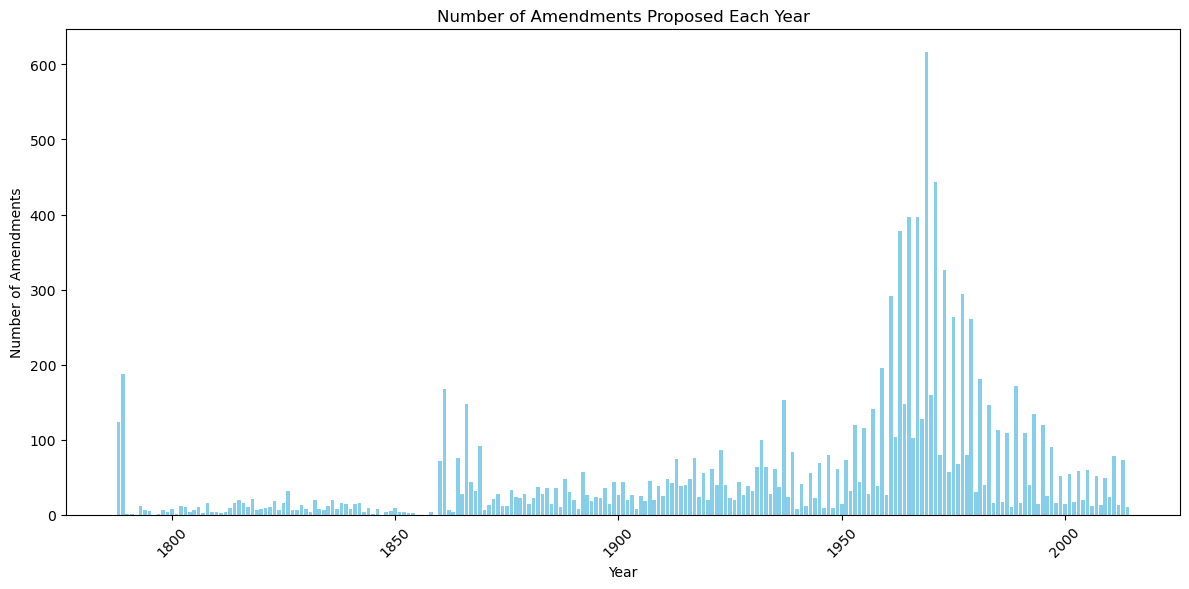

In [70]:
# Using the yearly_counts DataFrame, make a few figures to visualize the data
plt.figure(figsize=(12, 6))
plt.bar(yearly_counts['year'], yearly_counts['count'], color='skyblue')
plt.title('Number of Amendments Proposed Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Amendments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

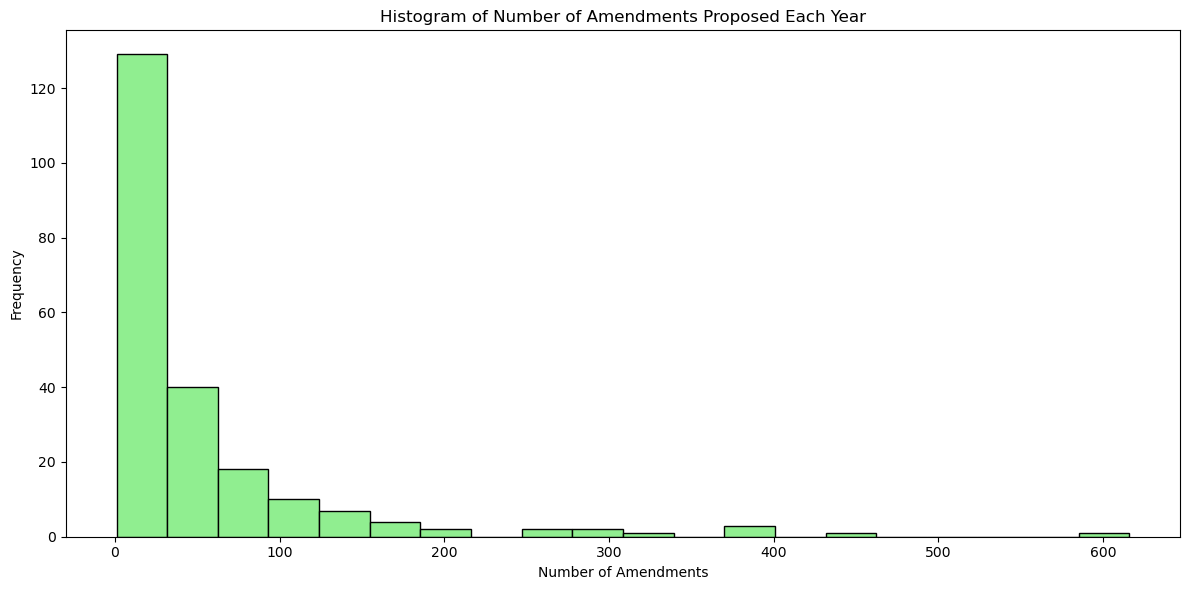

In [71]:
# A histogram of the frequency of amendments
plt.figure(figsize=(12, 6))
plt.hist(yearly_counts['count'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Histogram of Number of Amendments Proposed Each Year')
plt.xlabel('Number of Amendments')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [72]:
# Group the yearly_counts by count and get the number of years for each count, then sort by count
yearly_counts_sorted = yearly_counts.groupby('count').size().reset_index(name='years').sort_values(by='count')
print(yearly_counts_sorted.shape)
yearly_counts_sorted

(98, 2)


,count,years
0,1,5
1,2,4
2,3,3
3,4,9
4,5,2
...,...,...
93,326,1
94,378,1
95,397,2
96,444,1


In [73]:
# Check if any years don't have any proposed amendments
years_with_no_amendments = set(range(1788, 2014)) - set(yearly_counts['year'])
print(f"Years with no proposed amendments: {sorted(years_with_no_amendments)}")

Years with no proposed amendments: [1792, 1796, 1847, 1855, 1856, 1857, 1859]


In [74]:
# Number of amendments proposed each unique date
daily_counts = data.groupby(['year', 'month', 'day']).size().reset_index(name='count').sort_values(by=['year', 'month', 'day'])
daily_counts = daily_counts.sort_values(by='count', ascending=False)

# MM/DD/YYYY
daily_counts['date'] = [f"{int(row['month']):02d}/{int(row['day']):02d}/{int(row['year'])}" for index, row in daily_counts.iterrows()]
daily_counts = daily_counts[['date', 'count']].reset_index(drop=True)
print(daily_counts.shape)
daily_counts

print(f"Number of proposed amendments that didn't have valid dates: {data.shape[0] - daily_counts['count'].sum()}")

(5033, 2)
Number of proposed amendments that didn't have valid dates: 679
